In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
import datetime as dt
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

In [175]:
# Read the CSV file containing the power generation data (We drop ID's as we train on one plant)
gen_1=pd.read_csv('/Users/flo/Development/BetterSolar/BetterSolarBetaV0Python/Data/Static/Plant_1_Generation_Data.csv')
gen_1.drop('PLANT_ID',1,inplace=True)
# Read the CSV file containing external data inputs (such as weather, temperature...)
sens_1= pd.read_csv('/Users/flo/Development/BetterSolar/BetterSolarBetaV0Python/Data/Static/Plant_1_Weather_Sensor_Data.csv')
sens_1.drop('PLANT_ID',1,inplace=True)
#format datetime
gen_1['DATE_TIME']= pd.to_datetime(gen_1['DATE_TIME'],format='%d-%m-%Y %H:%M')
sens_1['DATE_TIME']= pd.to_datetime(sens_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

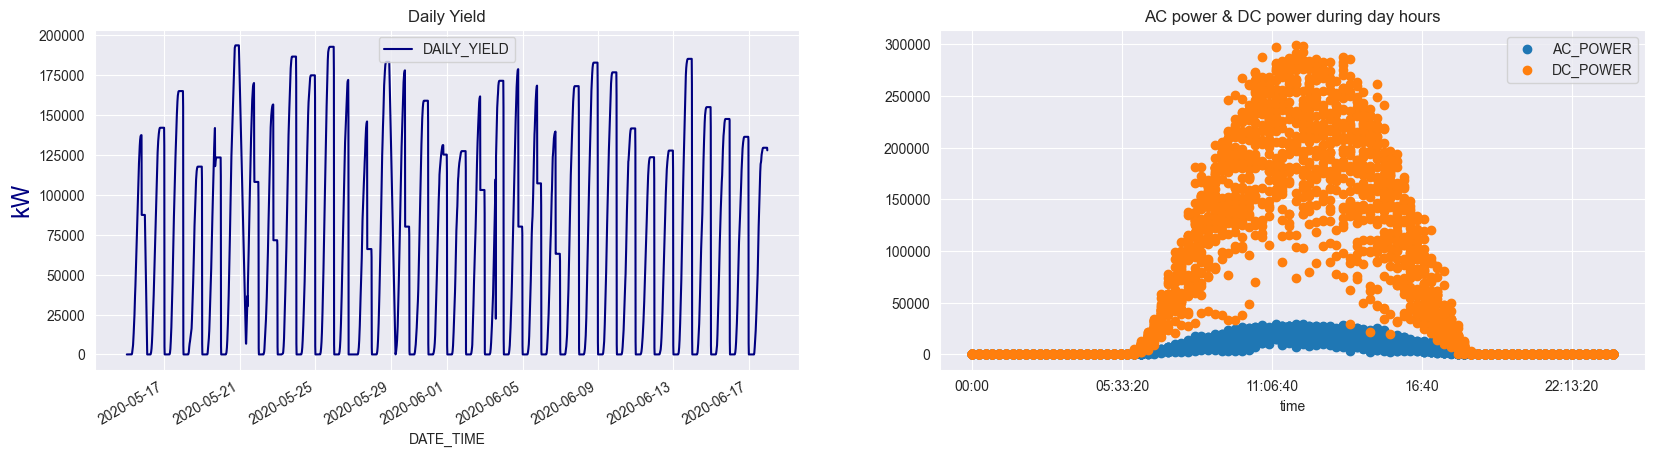

In [176]:
# Format time format
df_gen=gen_1.groupby('DATE_TIME').sum().reset_index()
df_gen['time']=df_gen['DATE_TIME'].dt.time
# Set up plot to inspect yields
fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# daily yield plot
df_gen.plot(x='DATE_TIME',y='DAILY_YIELD',color='navy',ax=ax[0])
# AC & DC power plot
df_gen.set_index('time').drop('DATE_TIME',1)[['AC_POWER','DC_POWER']].plot(style='o',ax=ax[1])

ax[0].set_title('Daily Yield',)
ax[1].set_title('AC power & DC power during day hours')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

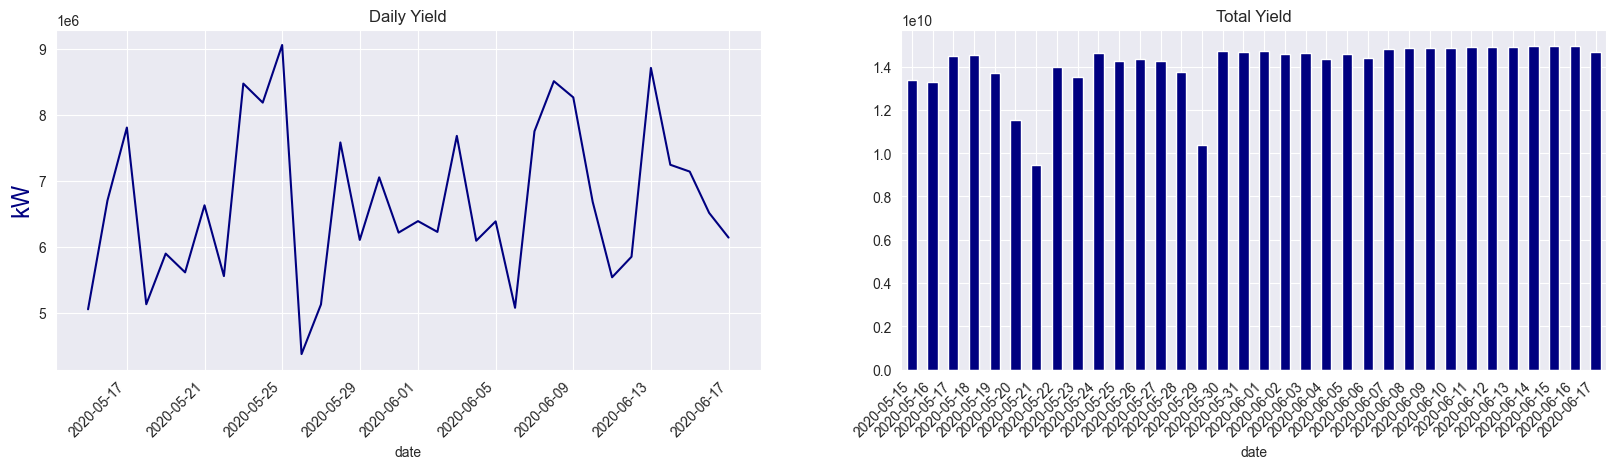

In [177]:
daily_gen=df_gen.copy()
daily_gen['date']=daily_gen['DATE_TIME'].dt.date

daily_gen=daily_gen.groupby('date').sum()

fig,ax= plt.subplots(ncols=2,dpi=100,figsize=(20,5))
daily_gen['DAILY_YIELD'].plot(ax=ax[0],color='navy')
daily_gen['TOTAL_YIELD'].plot(kind='bar',ax=ax[1],color='navy')
fig.autofmt_xdate(rotation=45)
ax[0].set_title('Daily Yield')
ax[1].set_title('Total Yield')
ax[0].set_ylabel('kW',color='navy',fontsize=17)
plt.show()

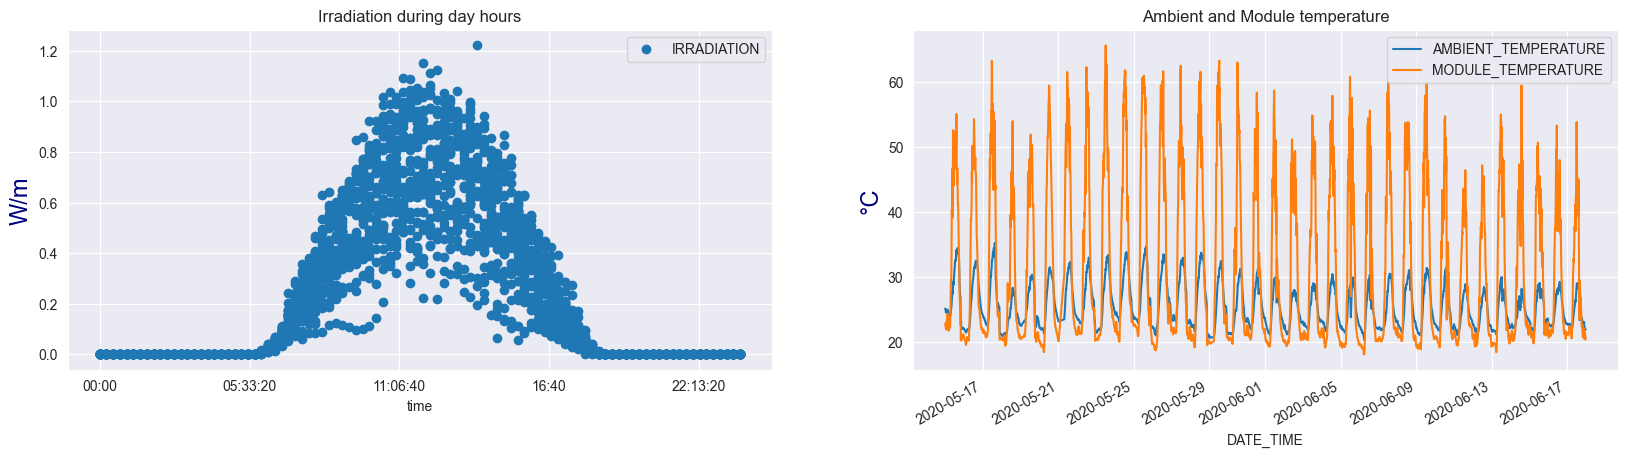

In [178]:
df_sens=sens_1.groupby('DATE_TIME').sum().reset_index()
df_sens['time']=df_sens['DATE_TIME'].dt.time

fig,ax = plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,5))
# daily yield plot
df_sens.plot(x='time',y='IRRADIATION',ax=ax[0],style='o')
# AC & DC power plot
df_sens.set_index('DATE_TIME').drop('time',1)[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']].plot(ax=ax[1])

ax[0].set_title('Irradiation during day hours',)
ax[1].set_title('Ambient and Module temperature')
ax[0].set_ylabel('W/m',color='navy',fontsize=17)
ax[1].set_ylabel('°C',color='navy',fontsize=17)


plt.show()

Solar Irridation seems to not be affected by neither the module- nor the ambient temperature.
This means power generation is not heavily dependent on the temperature.
Falty equipment on the other hand could be impacted by temperature.

We also need to inspect the power conversion.
Basic PV plant: Sun -> DC Power -> conversion -> AC power

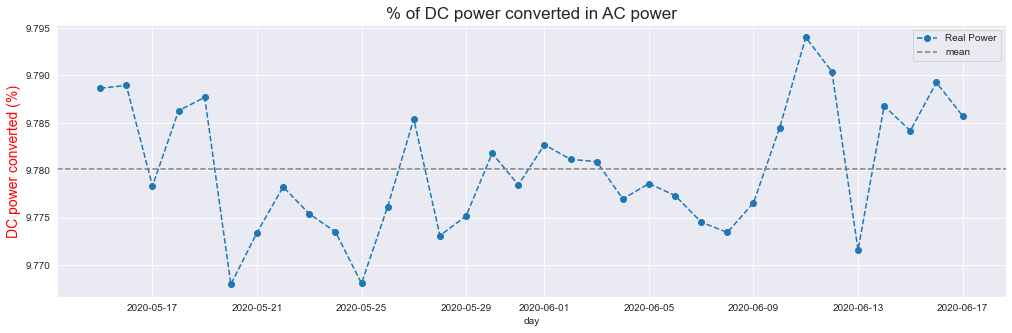

In [179]:
losses=gen_1.copy()
losses['day']=losses['DATE_TIME'].dt.date
losses=losses.groupby('day').sum()
losses['losses']=losses['AC_POWER']/losses['DC_POWER']*100

losses['losses'].plot(style='o--',figsize=(17,5),label='Real Power')

plt.title('% of DC power converted in AC power',size=17)
plt.ylabel('DC power converted (%)',fontsize=14,color='red')
plt.axhline(losses['losses'].mean(),linestyle='--',color='gray',label='mean')
plt.legend()
plt.show()

Only about 9% of the power gets converted. THis means the inverter has a lot of room for optimisation. 
We have different inverters that yield different outputs. We need to determine which inverters underperform. To do so, we'll check the DC Output by source.

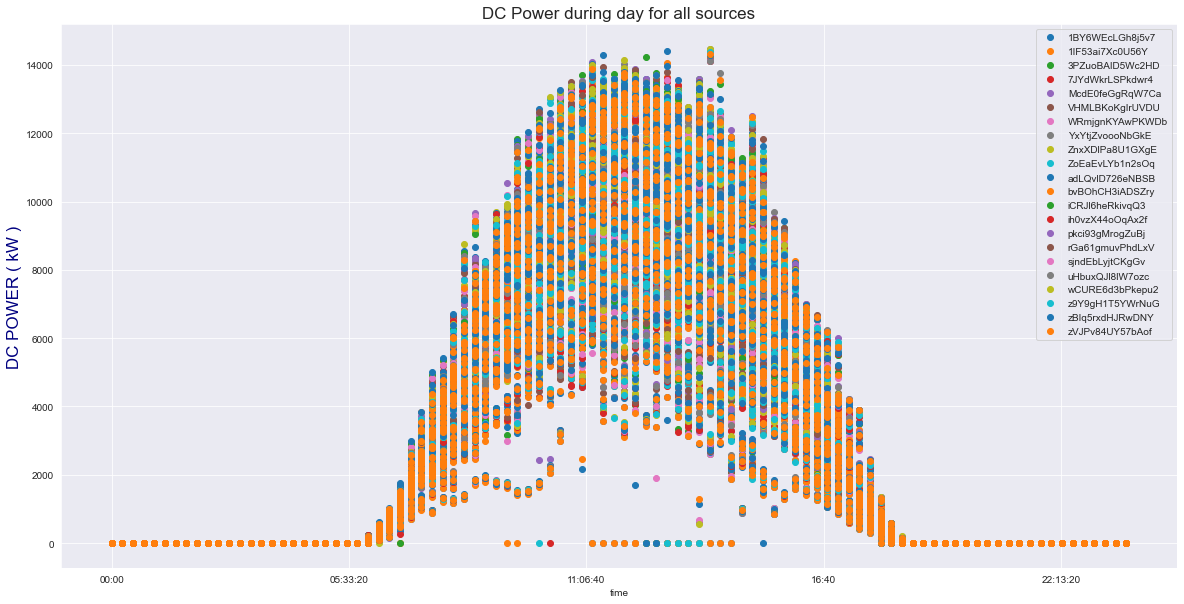

In [180]:
sources=gen_1.copy()
sources['time']=sources['DATE_TIME'].dt.time
sources.set_index('time').groupby('SOURCE_KEY')['DC_POWER'].plot(style='o',legend=True,figsize=(20,10))
plt.title('DC Power during day for all sources',size=17)
plt.ylabel('DC POWER ( kW )',color='navy',fontsize=17)
plt.show()

Note that we see outliers in the data during the day, which might indicate faulty inverters.


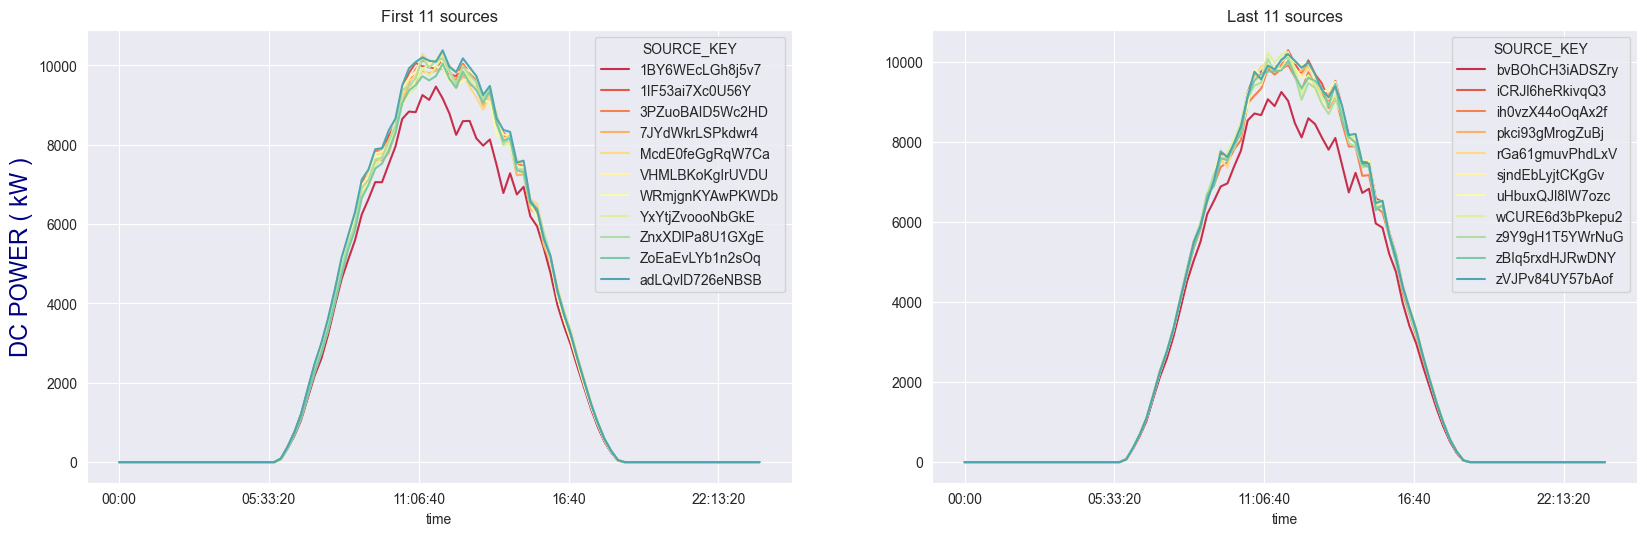

In [181]:
dc_gen=gen_1.copy()
dc_gen['time']=dc_gen['DATE_TIME'].dt.time
dc_gen=dc_gen.groupby(['time','SOURCE_KEY'])['DC_POWER'].mean().unstack()

cmap = sns.color_palette("Spectral", n_colors=12)

fig,ax=plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(20,6))
dc_gen.iloc[:,0:11].plot(ax=ax[0],color=cmap)
dc_gen.iloc[:,11:22].plot(ax=ax[1],color=cmap)

ax[0].set_title('First 11 sources')
ax[0].set_ylabel('DC POWER ( kW )',fontsize=17,color='navy')
ax[1].set_title('Last 11 sources')
plt.show()

We can see that some inverters are underperforming.
Why? Temperature? Weather?
Let's plot the output against some external data and see if we can draw any conclusions from the data.

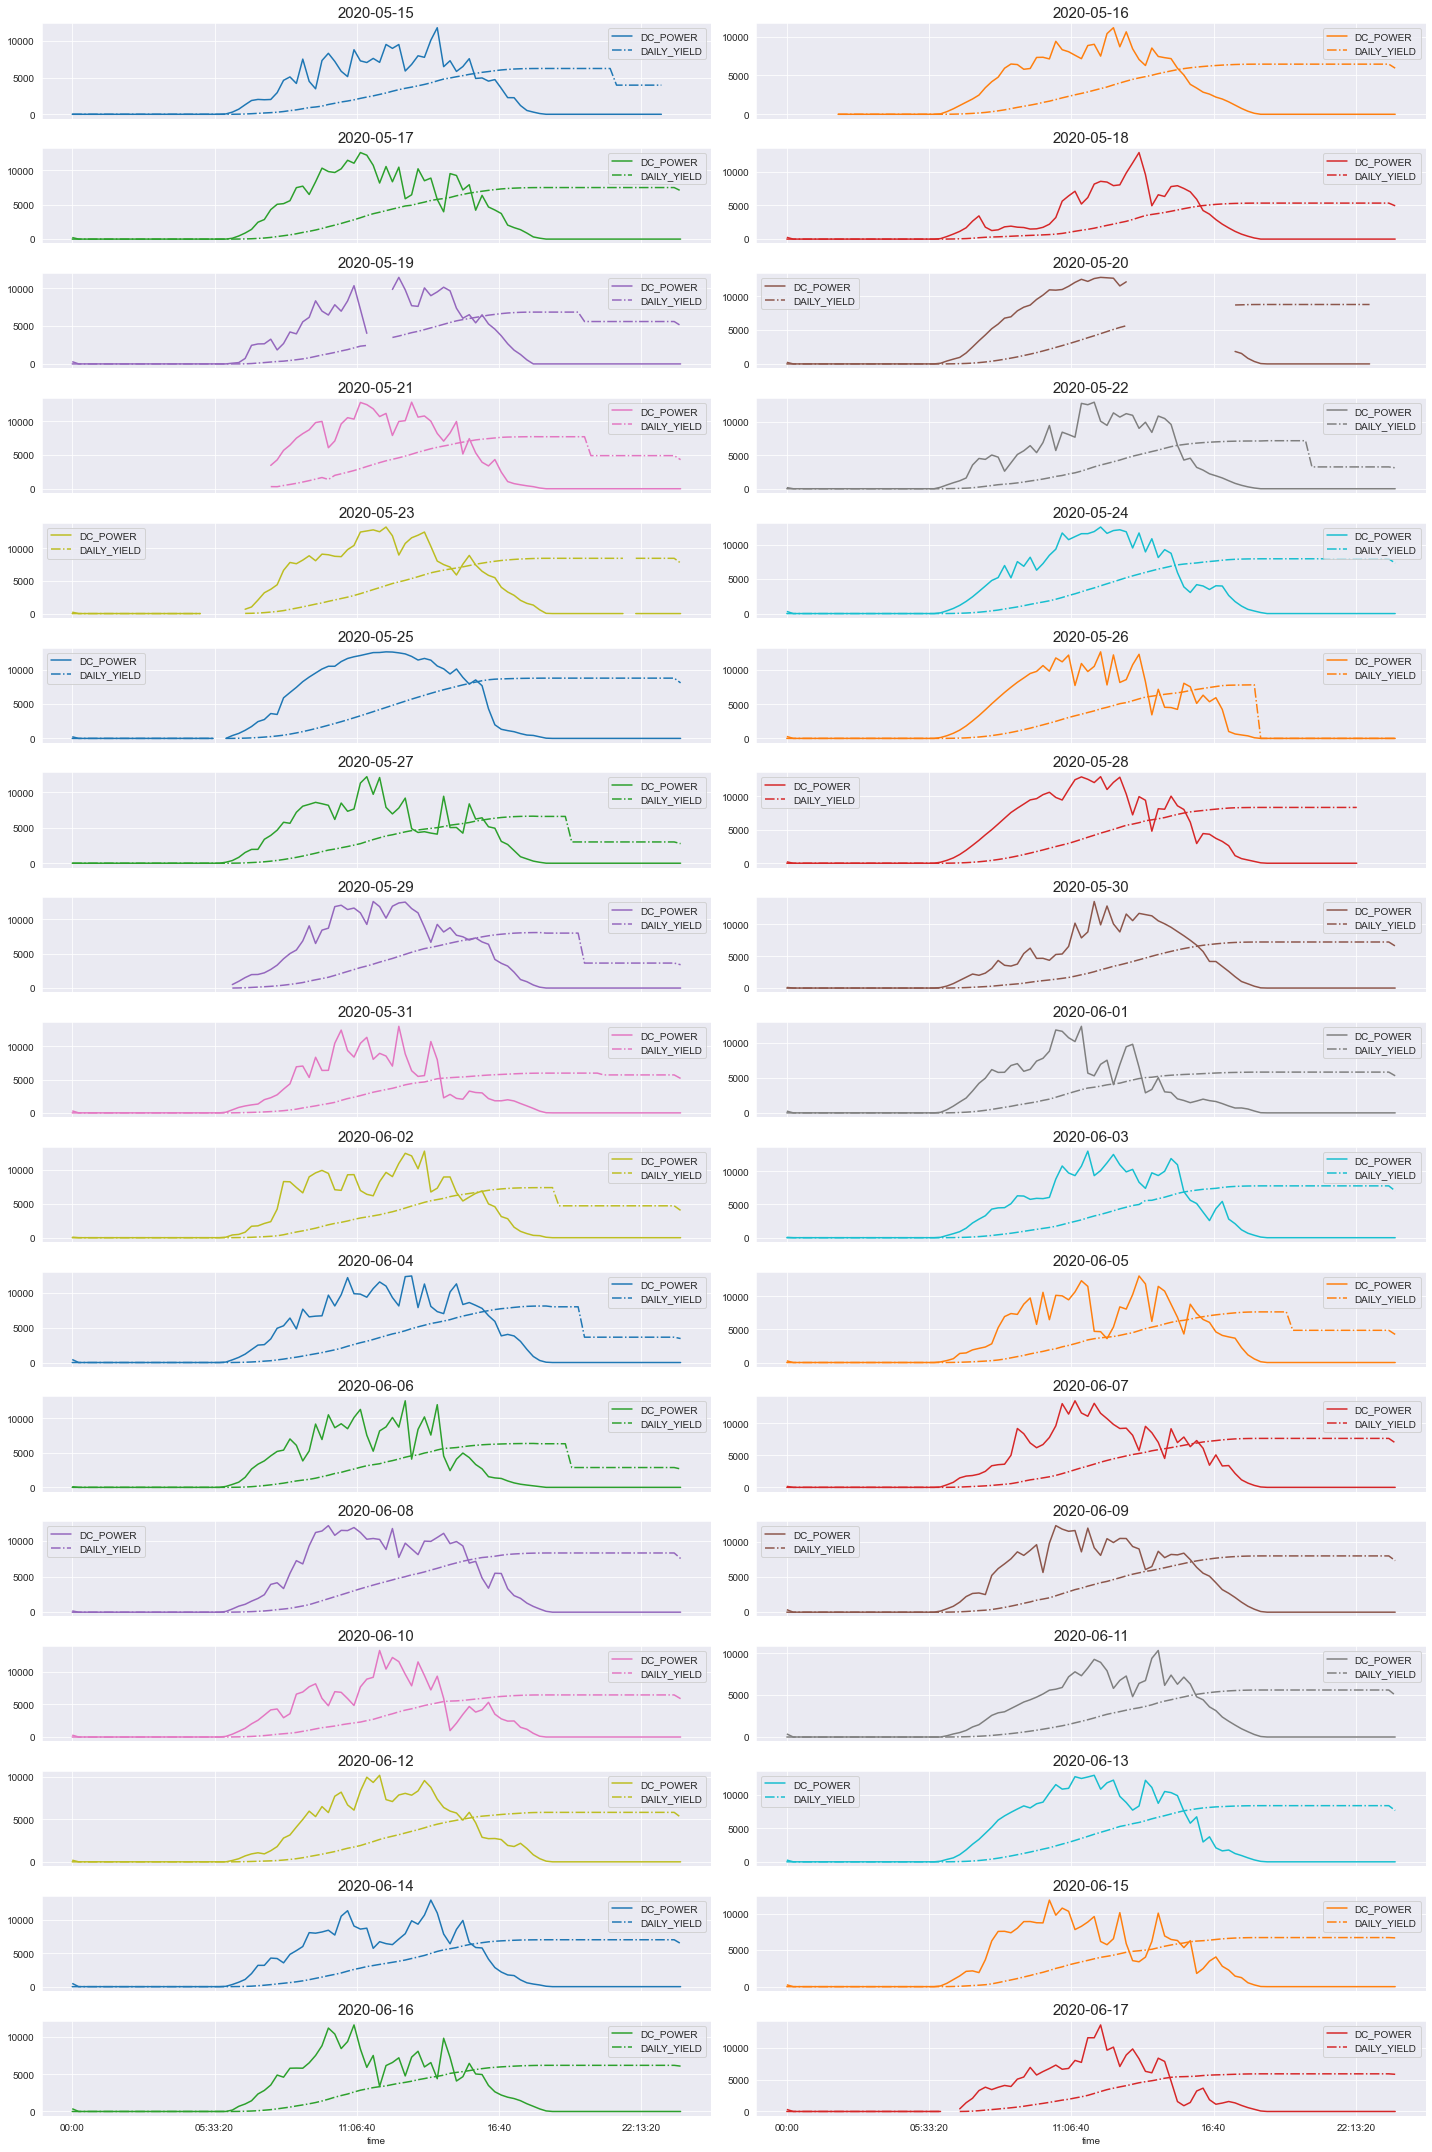

In [182]:
# We need to merge the dataframes in order to plot any sensor and generation data against each other.
temp1_gen=gen_1.copy()

temp1_gen['time']=temp1_gen['DATE_TIME'].dt.time
temp1_gen['day']=temp1_gen['DATE_TIME'].dt.date


temp1_sens=sens_1.copy()

temp1_sens['time']=temp1_sens['DATE_TIME'].dt.time
temp1_sens['day']=temp1_sens['DATE_TIME'].dt.date

# just for columns
cols=temp1_gen.groupby(['time','day'])['DC_POWER'].mean().unstack()

# Generate Plots
ax =temp1_gen.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30))
temp1_gen.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,20),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

In [183]:
sens_1.head


<bound method NDFrame.head of                DATE_TIME       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0    2020-05-15 00:00:00  HmiyD2TTLFNqkNe            25.184316   
1    2020-05-15 00:15:00  HmiyD2TTLFNqkNe            25.084589   
2    2020-05-15 00:30:00  HmiyD2TTLFNqkNe            24.935753   
3    2020-05-15 00:45:00  HmiyD2TTLFNqkNe            24.846130   
4    2020-05-15 01:00:00  HmiyD2TTLFNqkNe            24.621525   
...                  ...              ...                  ...   
3177 2020-06-17 22:45:00  HmiyD2TTLFNqkNe            22.150570   
3178 2020-06-17 23:00:00  HmiyD2TTLFNqkNe            22.129816   
3179 2020-06-17 23:15:00  HmiyD2TTLFNqkNe            22.008275   
3180 2020-06-17 23:30:00  HmiyD2TTLFNqkNe            21.969495   
3181 2020-06-17 23:45:00  HmiyD2TTLFNqkNe            21.909288   

      MODULE_TEMPERATURE  IRRADIATION  
0              22.857507          0.0  
1              22.761668          0.0  
2              22.592306          0.0  
3              22

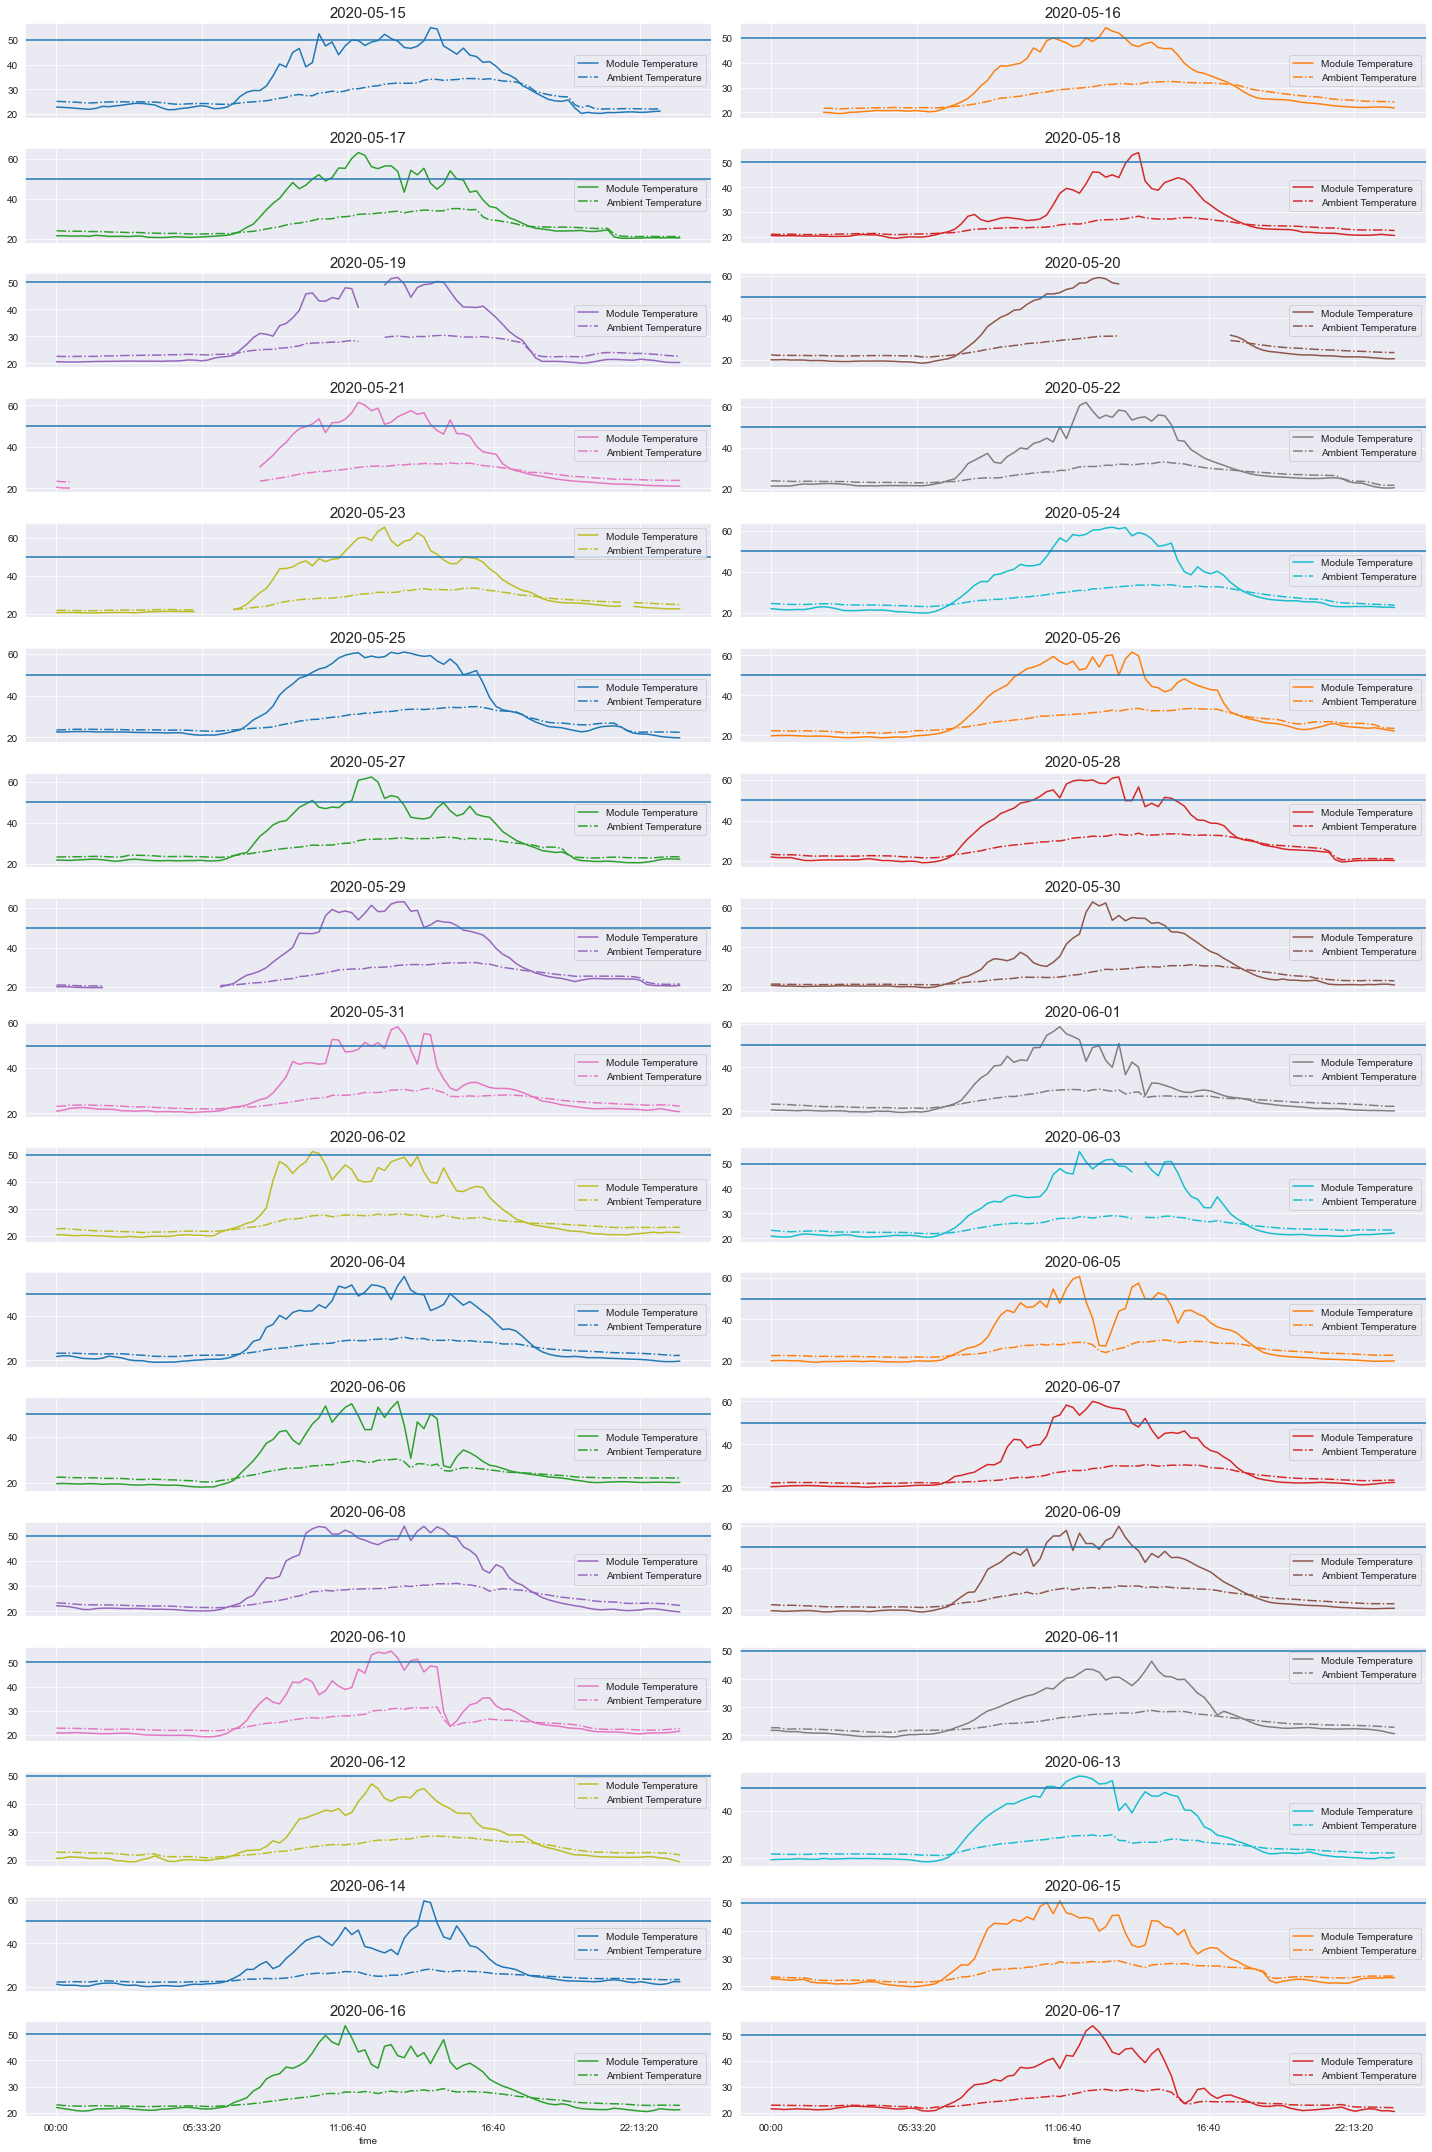

In [184]:
ax= temp1_sens.groupby(['time','day'])['MODULE_TEMPERATURE'].mean().unstack().plot(subplots=True,layout=(17,2),figsize=(20,30))
temp1_sens.groupby(['time','day'])['AMBIENT_TEMPERATURE'].mean().unstack().plot(subplots=True,layout=(17,2),figsize=(20,40),style='-.',ax=ax)

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].axhline(50)
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['Module Temperature','Ambient Temperature'])
        i=i+1

plt.tight_layout()
plt.show()

Now we can determine which inverters cause problems, as we can see, 
the output comes to an halt during sunlight in some cases. 
We have to assume that this is not only a data recording error, but a faulty inverter.

We need to further inspect the unusual behaviours of the inverter.

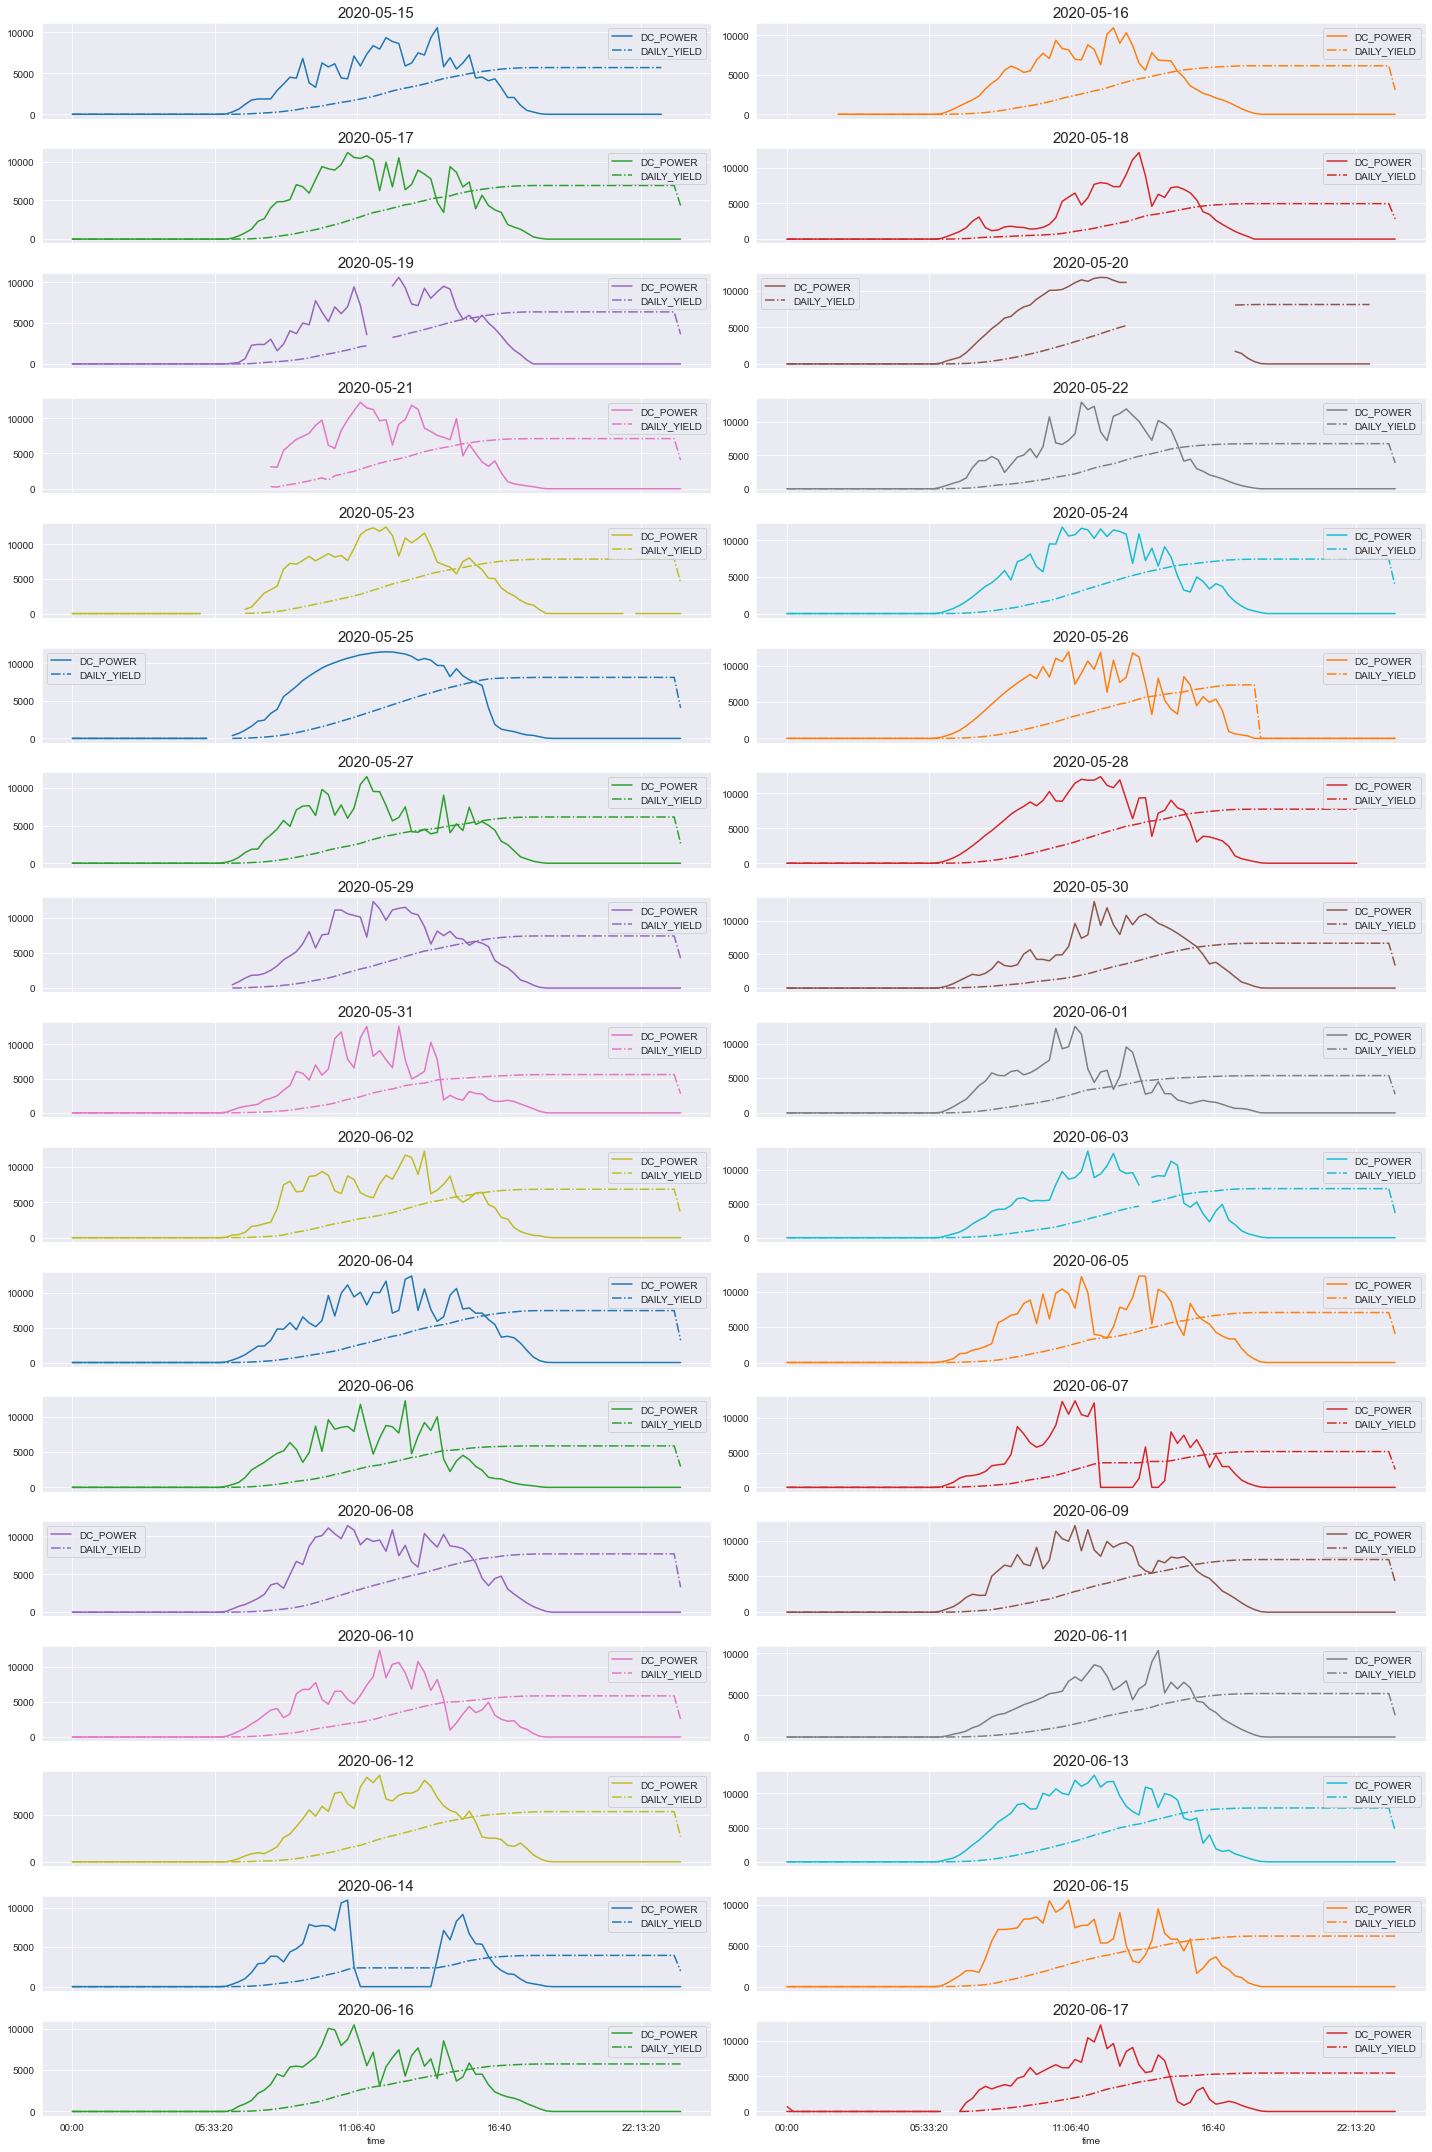

In [185]:
worst_source=gen_1[gen_1['SOURCE_KEY']=='bvBOhCH3iADSZry']
worst_source['time']=worst_source['DATE_TIME'].dt.time
worst_source['day']=worst_source['DATE_TIME'].dt.date

ax=worst_source.groupby(['time','day'])['DC_POWER'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30))
worst_source.groupby(['time','day'])['DAILY_YIELD'].mean().unstack().plot(sharex=True,subplots=True,layout=(17,2),figsize=(20,30),ax=ax,style='-.')

i=0
for a in range(len(ax)):
    for b in range(len(ax[a])):
        ax[a,b].set_title(cols.columns[i],size=15)
        ax[a,b].legend(['DC_POWER','DAILY_YIELD'])
        i=i+1

plt.tight_layout()
plt.show()

This far, we reviewed the data and tried to find faulty inverters.

Let's get to prediction - but first - we are going to test the null hypothesis.
We do this to see if data is stationary.
Remember, if the p value is smaller than 0,1 (some use 0,05), we conclude that we deal with a non stationary problem.

In [186]:
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

pred_gen=gen_1.copy()
pred_gen=pred_gen.groupby('DATE_TIME').sum()
pred_gen=pred_gen['DAILY_YIELD'][-288:].reset_index()
pred_gen.set_index('DATE_TIME',inplace=True)
pred_gen.head()


result = adfuller(pred_gen['DAILY_YIELD'])
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("Evidence against Null Hypothesis. Data has no unit root and is stationary")
else:
    print("Virtually no evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.2899376474793622
p-value : 0.17523382074929617
#Lags Used : 1
Number of Observations Used : 286
Virtually no evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Ok we have used the Augmented Dickey-Fuller unit root test and concluded
that the data is non-stationary. 
Let's do the standart data splitting for training.

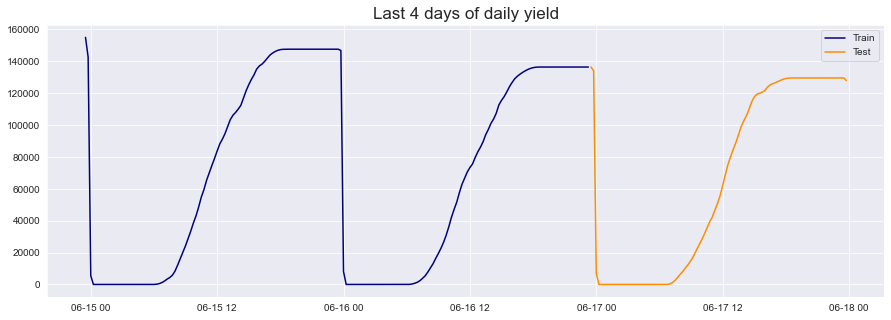

In [187]:
train=pred_gen[:192]
test=pred_gen[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='darkorange')
plt.title('Last 4 days of daily yield',fontsize=17)
plt.legend()
plt.show()

In [188]:
# Tensorflow Testing
# Data Engineering
import tensorflow as tf
from functools import reduce
dfs = [sens_1, temp1_gen]
# Merge Dataframes to train DL model
dfFinal = reduce(lambda left, right: pd.merge(left,right,on=["DATE_TIME"], how='outer'),dfs)
dfFinal = finalDf.drop("SOURCE_KEY_x",axis='columns').drop("time",axis='columns').drop("day",axis='columns').drop("SOURCE_KEY_y", axis='columns')

# Take every fourth record to predict hours rather than 15 min intervals
dfFinal = dfFinal[5::4]

date_time = pd.to_datetime(dfFinal.pop('DATE_TIME'), format='%Y.%m.%d %H:%M:%S')
# Normalize date time
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

dfFinal['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dfFinal['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dfFinal['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dfFinal['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

dfFinal = dfFinal.fillna(value=0)
column_indices = {name: i for i, name in enumerate(dfFinal.columns)}
n = len(dfFinal)
train_df = dfFinal[0:int(n*0.7)]
val_df = dfFinal[int(n*0.7):int(n*0.9)]
test_df = dfFinal[int(n*0.9):]


# # Normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

dfFinal.head

<bound method NDFrame.head of        AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  DC_POWER  \
5                25.184316           22.857507          0.0       0.0   
9                25.184316           22.857507          0.0       0.0   
13               25.184316           22.857507          0.0       0.0   
17               25.184316           22.857507          0.0       0.0   
21               25.084589           22.761668          0.0       0.0   
...                    ...                 ...          ...       ...   
68785            21.909288           20.427972          0.0       0.0   
68789            21.909288           20.427972          0.0       0.0   
68793            21.909288           20.427972          0.0       0.0   
68797            21.909288           20.427972          0.0       0.0   
68801             0.000000            0.000000          0.0    7545.0   

       AC_POWER  DAILY_YIELD  TOTAL_YIELD       Day sin   Day cos  Year sin  \
5           0.

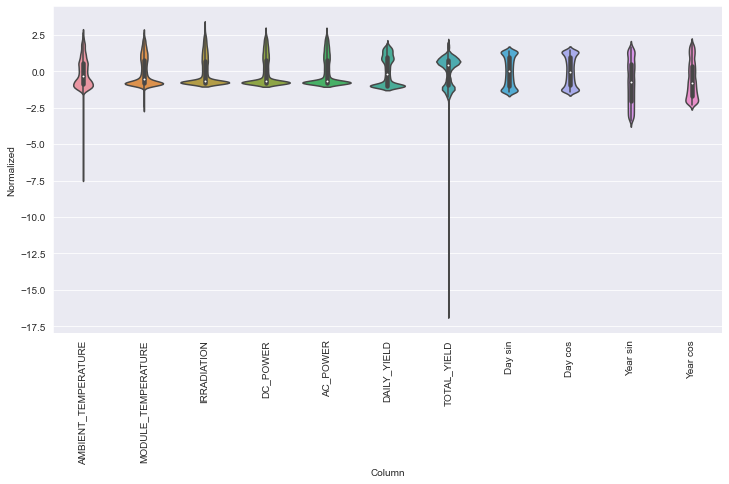

In [189]:
# Inspect feature distribution

df_std = (dfFinal - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfFinal.keys(), rotation=90)

We did all the necessary feature engineering to normalize the data, eliminate string and date values and split into Training, Test and CV data.

We now need to define the data windowing.
The main features of the input windows are:

The width (number of time steps) of the input and label windows.
The time offset between them.
Which features are used as inputs, labels, or both.

For example: 
Input width = 24
offset = 24
total width = 48
label width = 1

=

make a single prediction 24 hours into the future, given 24 hours of history

In [190]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [191]:
# For our example
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['TOTAL_YIELD'])
                     
w1                     

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['TOTAL_YIELD']

In [192]:
# Besides the data windowing we also need split windows
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [193]:
# Test
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 11)
Inputs shape: (3, 24, 11)
Labels shape: (3, 1, 1)


We now have engineered our data properly. We can finally start using Tensorflow by creating TF Datasets.

In [194]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [195]:
# Check if dataset engineering was successful
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 11)
Labels shape (batch, time, features): (32, 1, 1)


In [196]:
# Building a simple single step model with linear regression

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['TOTAL_YIELD'])
single_step_window

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


###################
# Baseline Model #
###################
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


Inputs shape (batch, time, features): (32, 1, 11)
Labels shape (batch, time, features): (32, 1, 1)


In [197]:
baseline = Baseline(label_index=column_indices['TOTAL_YIELD'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['TOTAL_YIELD'])

wide_window


108/108 [==============================] - 0s 837us/step - loss: 2.3082 - mean_absolute_error: 1.3794


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['TOTAL_YIELD']

In [219]:
# Linear Modelling
from tensorflow import keras
from tensorflow.keras import layers

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', dense(single_step_window.example[0]).shape)

MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Input shape: (32, 1, 11)
Output shape: (32, 1, 1)


In [212]:
# Now we can train the simple linear model and evaluate the performance

history = compile_and_fit(dense, single_step_window)

val_performance['Linear'] = dense.evaluate(single_step_window.val)
performance['Linear'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/15
377/377 [==============================] - 1s 2ms/step - loss: 0.8275 - mean_absolute_error: 0.6548 - val_loss: 0.3756 - val_mean_absolute_error: 0.4973
Epoch 2/15
377/377 [==============================] - 1s 2ms/step - loss: 0.6396 - mean_absolute_error: 0.5684 - val_loss: 0.4242 - val_mean_absolute_error: 0.5259
Epoch 3/15
377/377 [==============================] - 1s 2ms/step - loss: 0.6067 - mean_absolute_error: 0.5379 - val_loss: 0.2799 - val_mean_absolute_error: 0.4200
Epoch 4/15
377/377 [==============================] - 1s 2ms/step - loss: 0.5834 - mean_absolute_error: 0.5231 - val_loss: 0.6377 - val_mean_absolute_error: 0.5526
Epoch 5/15
108/108 [==============================] - 0s 939us/step - loss: 0.3797 - mean_absolute_error: 0.4695


In [217]:
# Bad performance due to single step model
# Need to train a multi time step model
import IPython
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['TOTAL_YIELD'])

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

108/108 [==============================] - 0s 935us/step - loss: 0.1123 - mean_absolute_error: 0.2834


In [220]:
# Better performance but still not satisfactory
# Not only performance is bad, but the input shape is fixed
# One way to tackle these problems is using CNN'sens_1
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)



108/108 [==============================] - 0s 971us/step - loss: 0.0300 - mean_absolute_error: 0.1410


In [222]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['TOTAL_YIELD'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['TOTAL_YIELD']

In [224]:
# LSTM Models

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


107/107 [==============================] - 0s 2ms/step - loss: 0.0288 - mean_absolute_error: 0.1099


Baseline    : 1.3811
Linear      : 0.5582
Multi step dense: 0.3516
Conv        : 0.1838
LSTM        : 0.2006


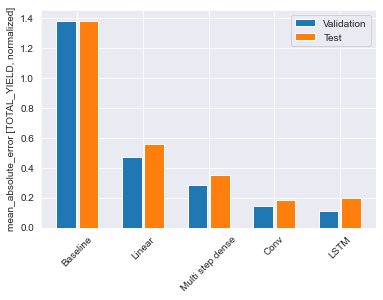

In [226]:
# Plot Evaluation

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [TOTAL_YIELD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')